# Basic imports

In [93]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime
import pandas as pd
import numpy as np
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.regression.linear_model import OLS
import os

# 1. Data Fetching & Data Pre-Processing

## 1.1. List all factors in the paper and factors we are interested

In [11]:
item1 = [ "Accruals", "NOA", "PS", "ZScore", "CompositeDebtIssuance", "ShareIss1Y", "XFIN", "ShareIss5Y", "FirmAge", "AssetGrowth", "ChNWC", "BookLeverage", "Illiquidity", "VolSD", "LRreversal", "IntMom", "Mom12m", "Mom6m", "High52", "MomSeasonShort", "MomSeason11YrPlus", "MomSeason06YrPlus", "MomSeason", "MomSeason16YrPlus", "Herf", "InvGrowth", "CBOperProf", "roaq", "RoE", "PM", "OperProf", "GP", "pchsaleinv", "Beta", "ChAssetTurnover", "STreversal", "Size", "cfp", "SP", "BM", "EP", "IdioVol3F", "MaxRet", "DolVol" ]
item2 = [ "Accruals", "OScore", "NOA", "ChNAnalyst", "ZScore", "FailureProbability", "EarningsSurprise", "CompEquIss", "FirmAge", "ChNWC", "MomVol", "CustomerMomentum", "BPEBM", "Illiquidity", "std_turn", "VolSD", "BetaLiquidityPS", "BetaBDLeverage", "DivSeason", "DivOmit", "DivInit", "ResidualMomentum", "Mom6mJunk", "CPVolSpread", "RIVolSpread", "MomSeasonShort", "MomSeason11YrPlus", "MomSeason06YrPlus", "MomOffSeason", "MomSeason", "MomOffSeason06YrPlus", "MomSeason16YrPlus", "MomOffSeason16YrPlus", "RDAbility", "MomOffSeason11YrPlus", "roaq", "RoE", "PM", "Coskewness", "ChAssetTurnover", "ChPM", "ShareVol", "BM", "EP", "Frontier", "CF", "EBM", "AnalystValue", "DivYield", "VolMkt" ]

csv_list = item1 + item2
# delete the duplicate items
csv_list = list(set(csv_list))
len(csv_list)

76

## 1.2. Ensure the factor file could be found(Need Factor Data)

In [12]:
cd = 'CtsPredictorQuintileVW'
df = pd.DataFrame()
missing_files = []

for file in csv_list:
    file_path = f'{cd}/{file}_ret.csv'
    if os.path.exists(file_path):
        temp_df = pd.read_csv(file_path)
        factor_name = file  
        temp_df['predictor'] = factor_name  
        df = pd.concat([df, temp_df], ignore_index=True)
    else:
        missing_files.append(file_path)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['predictor', 'date'], inplace=True)
df

,date,port01,port02,port03,port04,port05,portLS,predictor
729584,1952-07-01,0.124831,0.336154,0.839240,0.637685,0.656345,0.531514,Accruals
729585,1952-07-02,-0.246625,-0.244496,-0.049348,-0.189462,-0.104565,0.142060,Accruals
729586,1952-07-03,0.023978,0.084967,-0.142413,-0.223899,-0.035177,-0.059155,Accruals
729587,1952-07-07,-0.171018,-0.076185,-0.263179,-0.661418,-0.503844,-0.332827,Accruals
729588,1952-07-08,-0.209479,0.235904,-0.025679,0.218441,0.140033,0.349512,Accruals
...,...,...,...,...,...,...,...,...
791052,2023-12-22,1.857859,0.723824,0.498934,0.233261,0.428393,-1.429466,std_turn
791053,2023-12-26,3.266919,0.875071,1.303056,0.540725,0.561904,-2.705015,std_turn
791054,2023-12-27,2.341186,0.200744,0.285204,0.159429,0.059149,-2.282037,std_turn
791055,2023-12-28,-1.669881,-0.263774,-0.543158,-0.266308,-0.110725,1.559157,std_turn


## 1.3. Save the merged factor list to csv file

In [13]:
# get the unique factors
unique_factors = df['predictor'].nunique()
print(f'Unique factor number is {unique_factors}')

with open('factors.txt', 'w') as f:
	f.write(str(unique_factors))

# get the missed files
if missing_files:
    print("The following files were not found:")
    for missing_file in missing_files:
        print(missing_file)

# save the merged DataFrame to a csv file
df.to_csv(f'data/merged_data.csv', index=False)

Unique factor number is 62
The following files were not found:
CtsPredictorQuintileVW/ZScore_ret.csv
CtsPredictorQuintileVW/MomVol_ret.csv
CtsPredictorQuintileVW/DivInit_ret.csv
CtsPredictorQuintileVW/ShareVol_ret.csv
CtsPredictorQuintileVW/BetaBDLeverage_ret.csv
CtsPredictorQuintileVW/pchsaleinv_ret.csv
CtsPredictorQuintileVW/DivSeason_ret.csv
CtsPredictorQuintileVW/OScore_ret.csv
CtsPredictorQuintileVW/PM_ret.csv
CtsPredictorQuintileVW/FailureProbability_ret.csv
CtsPredictorQuintileVW/DivOmit_ret.csv
CtsPredictorQuintileVW/ChPM_ret.csv
CtsPredictorQuintileVW/DivYield_ret.csv
CtsPredictorQuintileVW/ChNAnalyst_ret.csv


# 2. Replicate Table 1

## 2.1. merged data

* First, according to the research ideas of the paper, we integrate the factor return data with Fama’s 3-factor and 5-factor models.

In [2]:
table1_data = pd.read_csv('data/merged_data.csv')
table1_ff3 = pd.read_csv('data/FF3_daily.csv')
table1_ff5 = pd.read_csv('data/FF5_daily.csv')

In [3]:
table1_ff3.columns =['date','Mkt-RF','SMB','HML','RF']
table1_ff5.columns =['date','Mkt-RF','SMB','HML','RMW','CMA','RF']
print(table1_data.columns.tolist())
print(table1_ff3.columns.tolist())
print(table1_ff5.columns.tolist())

table1_ff3.dtypes

['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor']
['date', 'Mkt-RF', 'SMB', 'HML', 'RF']
['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']


date        int64
Mkt-RF    float64
SMB       float64
HML       float64
RF        float64
dtype: object

In [4]:
table1_data['date']= pd.to_datetime(table1_data['date']).dt.strftime('%Y-%m-%d')

In [5]:
table1_data

,date,port01,port02,port03,port04,port05,portLS,predictor
0,1952-07-01,0.124831,0.336154,0.839240,0.637685,0.656345,0.531514,Accruals
1,1952-07-02,-0.246625,-0.244496,-0.049348,-0.189462,-0.104565,0.142060,Accruals
2,1952-07-03,0.023978,0.084967,-0.142413,-0.223899,-0.035177,-0.059155,Accruals
3,1952-07-07,-0.171018,-0.076185,-0.263179,-0.661418,-0.503844,-0.332827,Accruals
4,1952-07-08,-0.209479,0.235904,-0.025679,0.218441,0.140033,0.349512,Accruals
...,...,...,...,...,...,...,...,...
1237143,2023-12-22,1.857859,0.723824,0.498934,0.233261,0.428393,-1.429466,std_turn
1237144,2023-12-26,3.266919,0.875071,1.303056,0.540725,0.561904,-2.705015,std_turn
1237145,2023-12-27,2.341186,0.200744,0.285204,0.159429,0.059149,-2.282037,std_turn
1237146,2023-12-28,-1.669881,-0.263774,-0.543158,-0.266308,-0.110725,1.559157,std_turn


In [6]:
table1_ff3['date'] = pd.to_datetime(table1_ff3['date'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m-%d')
table1_ff3

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.10,-0.25,-0.27,0.009
1,1926-07-02,0.45,-0.33,-0.06,0.009
2,1926-07-06,0.17,0.30,-0.39,0.009
3,1926-07-07,0.09,-0.58,0.02,0.009
4,1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...,...
25896,2024-12-24,1.11,-0.09,-0.05,0.017
25897,2024-12-26,0.02,1.04,-0.19,0.017
25898,2024-12-27,-1.17,-0.66,0.56,0.017
25899,2024-12-30,-1.09,0.12,0.74,0.017


In [7]:
table1_ff5['date'] = pd.to_datetime(table1_ff5['date'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m-%d')
table1_ff5

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15476,2024-12-24,1.11,-0.12,-0.05,-0.13,-0.37,0.017
15477,2024-12-26,0.02,1.09,-0.19,-0.44,0.35,0.017
15478,2024-12-27,-1.17,-0.44,0.56,0.41,0.03,0.017
15479,2024-12-30,-1.09,0.24,0.74,0.55,0.14,0.017


In [8]:
table1_ff3.head()
table1_ff3.dtypes

date       object
Mkt-RF    float64
SMB       float64
HML       float64
RF        float64
dtype: object

## 2.2.Divided the time & dataset

* The data analysis timeline of the paper is from 1963 to 2016. Combined with the data obtained by the team, we divided the research time into four groups: 2000_2016, 2017-2023, 2000-2023, and 1963-2016, in order to explore the impact of long, medium and short time on factor regression.

In [9]:
# all period from 2000 Jan 1 to 2023 Dec 31
start_date = '2000-01-01'
end_date = '2023-12-31'

In [10]:
# sample period from 2000 Jan 1 to 2016 Dec 31
start_date_1 = '2000-01-01'
end_date_1 = '2016-12-31'

In [11]:
# post sample period from 2017 Jan 1 to 2023 Dec 31
start_date_2 = '2017-01-01'
end_date_2 = '2023-12-31'

In [12]:
# original sample period from 1963 July 1 to 2016 Dec 31
start_date_3 = '1963-07-01'
end_date_3 = '2016-12-31'

In [13]:
# Adjust for the time
filtered_data_1 = table1_data[(table1_data['date'] >= start_date) & (table1_data['date'] <= end_date)]
filtered_ff3_1 = table1_ff3[(table1_ff3['date'] >= start_date) & (table1_ff3['date'] <= end_date)]
filtered_ff5_1 = table1_ff5[(table1_ff5['date'] >= start_date) & (table1_ff5['date'] <= end_date)]
filtered_data_2 = table1_data[(table1_data['date'] >= start_date_1) & (table1_data['date'] <= end_date_1)]
filtered_ff3_2 = table1_ff3[(table1_ff3['date'] >= start_date_1) & (table1_ff3['date'] <= end_date_1)]
filtered_ff5_2 = table1_ff5[(table1_ff5['date'] >= start_date_1) & (table1_ff5['date'] <= end_date_1)]
filtered_data_3 = table1_data[(table1_data['date'] >= start_date_2) & (table1_data['date'] <= end_date_2)]
filtered_ff3_3 = table1_ff3[(table1_ff3['date'] >= start_date_2) & (table1_ff3['date'] <= end_date_2)]
filtered_ff5_3 = table1_ff5[(table1_ff5['date'] >= start_date_2) & (table1_ff5['date'] <= end_date_2)]
# Adjust for factors data in the original sample period, ensure all factors are available
check_factor_original = table1_data[table1_data['date'] < start_date_3]['predictor'].unique()
filtered_data_4 = table1_data[table1_data['predictor'].isin(check_factor_original)]
filtered_data_4 = filtered_data_4[(filtered_data_4['date'] >= start_date_3) & (filtered_data_4['date'] <= end_date_3)]
# Adjust for ff data time
filtered_ff3_4 = table1_ff3[(table1_ff3['date'] >= start_date_3) & (table1_ff3['date'] <= end_date_3)]
filtered_ff5_4 = table1_ff5[(table1_ff5['date'] >= start_date_3) & (table1_ff5['date'] <= end_date_3)]

In [14]:
merged_data_1 = pd.merge(filtered_data_1, filtered_ff3_1, on='date', how='inner')
merged_data_2 = pd.merge(filtered_data_1, filtered_ff5_1, on='date', how='inner')
merged_data_3 = pd.merge(filtered_data_2, filtered_ff3_2, on='date', how='inner')
merged_data_4 = pd.merge(filtered_data_2, filtered_ff5_2, on='date', how='inner')
merged_data_5 = pd.merge(filtered_data_3, filtered_ff3_3, on='date', how='inner')
merged_data_6 = pd.merge(filtered_data_3, filtered_ff5_3, on='date', how='inner')
merged_data_7 = pd.merge(filtered_data_4, filtered_ff3_4, on='date', how='inner')
merged_data_8 = pd.merge(filtered_data_4, filtered_ff5_4, on='date', how='inner')

print(merged_data_1.columns.tolist())
print(merged_data_2.columns.tolist())
print(merged_data_3.columns.tolist())
print(merged_data_4.columns.tolist())
print(merged_data_5.columns.tolist())
print(merged_data_6.columns.tolist())
print(merged_data_7.columns.tolist())
print(merged_data_8.columns.tolist())

['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RF']
['date', 'port01', 'port02', 'port03', 'port04', 'port05', 'portLS', 'predictor', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']


In [15]:
merged_data_1.to_csv('data/merged_data_with_ff3_1.csv', index=False)
merged_data_2.to_csv('data/merged_data_with_ff5_1.csv', index=False)
merged_data_3.to_csv('data/merged_data_with_ff3_2.csv', index=False)
merged_data_4.to_csv('data/merged_data_with_ff5_2.csv', index=False)
merged_data_5.to_csv('data/merged_data_with_ff3_3.csv', index=False)
merged_data_6.to_csv('data/merged_data_with_ff5_3.csv', index=False)
merged_data_7.to_csv('data/merged_data_with_ff3_4.csv', index=False)
merged_data_8.to_csv('data/merged_data_with_ff5_4.csv', index=False)

In [16]:
# print the unique 'predictor' in the original sample period
check_factor_original

array(['Accruals', 'AssetGrowth', 'BM', 'BPEBM', 'Beta', 'BookLeverage',
       'CBOperProf', 'CF', 'ChAssetTurnover', 'ChNWC', 'CompEquIss',
       'CompositeDebtIssuance', 'Coskewness', 'DolVol', 'EBM', 'EP',
       'EarningsSurprise', 'FirmAge', 'GP', 'Herf', 'High52', 'IdioVol3F',
       'Illiquidity', 'IntMom', 'InvGrowth', 'LRreversal', 'MaxRet',
       'Mom12m', 'Mom6m', 'MomOffSeason', 'MomOffSeason06YrPlus',
       'MomOffSeason11YrPlus', 'MomOffSeason16YrPlus', 'MomSeason',
       'MomSeason06YrPlus', 'MomSeason11YrPlus', 'MomSeason16YrPlus',
       'MomSeasonShort', 'NOA', 'RDAbility', 'ResidualMomentum', 'RoE',
       'SP', 'STreversal', 'ShareIss1Y', 'ShareIss5Y', 'Size', 'VolMkt',
       'VolSD', 'std_turn'], dtype=object)

In [17]:
# Define for accounting factors and return factors for "all" "sample" and "post" periods
accounting_factors = [
    'Accruals', 'AnalystValue', 'AssetGrowth', 'BM', 'BPEBM', 'BookLeverage',
    'CBOperProf', 'CF', 'ChAssetTurnover', 'ChNWC', 'CompEquIss', 'CompositeDebtIssuance',
    'EBM', 'EP', 'EarningsSurprise', 'GP', 'Herf', 'InvGrowth',
    'NOA', 'OperProf', 'PS', 'RDAbility', 'RoE', 'SP', 'Size', 'ShareIss1Y', 'ShareIss5Y',
    'XFIN', 'cfp', 'roaq'
]

return_factors = [
    'Beta', 'BetaLiquidityPS', 'CPVolSpread', 'Coskewness', 'CustomerMomentum',
    'DolVol', 'FirmAge', 'High52', 'IdioVol3F', 'Illiquidity', 'IntMom', 'LRreversal', 'MaxRet',
    'Mom12m', 'Mom6m', 'Mom6mJunk', 'MomOffSeason', 'MomOffSeason06YrPlus',
    'MomOffSeason11YrPlus', 'MomOffSeason16YrPlus', 'MomSeason', 'MomSeason06YrPlus',
    'MomSeason11YrPlus', 'MomSeason16YrPlus', 'MomSeasonShort', 'RIVolSpread',
    'ResidualMomentum', 'STreversal', 'VolMkt', 'VolSD', 'std_turn', 'Frontier'
]

In [18]:
# Define for accounting factors and return factors for "original" sample period
accounting_factors_original = [
    'Accruals', 'AssetGrowth', 'BM', 'BPEBM', 'BookLeverage', 'CBOperProf', 'CF', 'ChAssetTurnover', 'ChNWC', 'CompEquIss', 'CompositeDebtIssuance', 'EBM', 'EP', 'EarningsSurprise', 'GP', 'Herf', 'InvGrowth', 'NOA', 'RDAbility', 'RoE', 'SP', 'Size', 'ShareIss1Y', 'ShareIss5Y'
]

return_factors_original = [
    'Beta', 'Coskewness', 'DolVol', 'FirmAge', 'High52', 'IdioVol3F', 'Illiquidity', 'IntMom', 'LRreversal', 'MaxRet', 'Mom12m', 'Mom6m', 'MomOffSeason', 'MomOffSeason06YrPlus', 'MomOffSeason11YrPlus', 'MomOffSeason16YrPlus', 'MomSeason', 'MomSeason06YrPlus', 'MomSeason11YrPlus', 'MomSeason16YrPlus', 'MomSeasonShort', 'ResidualMomentum', 'STreversal', 'VolMkt', 'VolSD', 'std_turn'
]

## 2.3. regression in the ‘all' time period

* In this section, calculations and regression studies will be conducted for the timeline 2000-2023.
* In the first step, we will calculate the first two columns of Table 1 to obtain the average return rate and t value of each factor.
* The second step is to calculate the regression results of each factor and the FF3 factor model, and output the excess return and the corresponding t value.
* The third step is to calculate the regression results of each factor and the FF5 factor model. The overall idea is similar to the second step.

+ <span style="color:red">The Newey-West standard error can effectively deal with heteroscedasticity by adjusting the covariance matrix. At the same time, the Newey-West method introduces a lag term to correct the autocorrelation and provide a more accurate standard error.</span>

### 3.1 Preliminary analysis

In [26]:
# Read the merged data
all_data = pd.read_csv('data/merged_data_with_ff3_1.csv')
# Divide by 100
port_columns_1 = ['port01', 'port02', 'port03', 'port04', 'port05']
all_data[port_columns_1] = all_data[port_columns_1] / 100
# only retain columns that are needed
all_data = all_data[['date', 'predictor'] + port_columns_1]

# Separate accounting and return data
accounting_data_1 = all_data[all_data['predictor'].isin(accounting_factors)]
return_data_1 = all_data[all_data['predictor'].isin(return_factors)]

In [27]:
# Calculate the dynamic factor return
def calculate_dynamic_factor_return(row):
    high_ports = row[['port04', 'port05']].values
    low_ports = row[['port01', 'port02']].values
    return np.mean(high_ports) - np.mean(low_ports)

# Define a function to compound returns
def compound_returns(x):
    return (1 + x).prod() - 1

# Resample and calculate dynamic factor return for each period
def resample_and_calculate(df, freq):
    df['date'] = pd.to_datetime(df['date'])
    df_resampled = df.set_index('date').groupby('predictor').resample(freq).apply(compound_returns).reset_index()
    return df_resampled

# Calculate Newey-West t-value
def calculate_newey_west_t_value(df, max_lag):
    results = []

    for factor, group in df.groupby('predictor'):
        returns = group['factor_return'].dropna()
        mean_returns = returns.mean() * 100  # Calculate mean returns for each factor

        # Regression to compute t-stat using Newey-West standard errors
        X = sm.add_constant(np.ones(len(returns)))  # Constant term
        model = sm.OLS(returns, X).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})

        t_value = model.tvalues.iloc[0]  # T-Value

        # display results in 2 decimal places
        results.append({
            'Factor': factor,
            'Average Returns': round(mean_returns, 2),
            'T-Value': round(t_value, 2)
        })

    return pd.DataFrame(results)

In [28]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [29]:
# Resample accounting data annually
accounting_data_resampled = resample_and_calculate(accounting_data_1, 'YE')

# Resample return data monthly
return_data_resampled = resample_and_calculate(return_data_1, 'ME')

# Calculate dynamic factor return
accounting_data_resampled['factor_return'] = accounting_data_resampled.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled['factor_return'] = return_data_resampled.apply(calculate_dynamic_factor_return, axis=1)

# Calculate stats for accounting data
accounting_results_1 = calculate_newey_west_t_value(accounting_data_resampled, max_lag=1)

# Calculate stats for return data
return_results_1 = calculate_newey_west_t_value(return_data_resampled, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_1)

print("\nReturn factors (monthly rebalancing):")
print(return_results_1)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value
0                Accruals             1.86     1.38
1            AnalystValue             3.30     0.85
2             AssetGrowth             2.22     0.93
3                      BM             3.23     1.07
4                   BPEBM             2.52     1.57
5            BookLeverage            -2.14    -1.10
6              CBOperProf             3.50     2.12
7                      CF             2.64     0.95
8         ChAssetTurnover            -0.55    -0.60
9                   ChNWC            -1.46    -1.65
10             CompEquIss             2.83     1.32
11  CompositeDebtIssuance             0.48     0.28
12                    EBM             0.22     0.08
13                     EP             3.71     1.44
14       EarningsSurprise             1.41     1.47
15                     GP             4.73     2.24
16                   Herf            -1.42    -1.04
17              InvGro

### 3.2 Regression 1 - FF3

In [30]:
# read the merged data
all_data_2 = pd.read_csv('data/merged_data_with_ff3_1.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RF']
all_data_2[port_columns] = all_data_2[port_columns] / 100
# only retain columns that are needed
all_data_2 = all_data_2[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_2 = all_data_2[all_data_2['predictor'].isin(accounting_factors)]
return_data_2 = all_data_2[all_data_2['predictor'].isin(return_factors)]

In [31]:
# Calculate alpha and Newey-West t-value
def calculate_ff3_alpha_and_tvalues(df, max_lag):
    results = []

    for factor, group in df.groupby('predictor'):
        group = group.dropna(subset=['factor_return', 'RF', 'Mkt-RF', 'SMB', 'HML'])
        y = group['factor_return'] - group['RF']
        X = sm.add_constant(group[['Mkt-RF', 'SMB', 'HML']])  # FF3 factors

        # Perform regression with Newey-West standard errors
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})

        alpha = model.params['const'] * 100  # FF3 Alpha
        t_value = model.tvalues['const']  # T-Value

        results.append({
            'Factor': factor,
            'FF3 Alpha': round(alpha, 2),
            'T-Value': round(t_value, 2)
        })

    return pd.DataFrame(results)

In [33]:
# Resample accounting data annually
accounting_data_resampled_2 = resample_and_calculate(accounting_data_2, 'YE')

# Resample return data monthly
return_data_resampled_2 = resample_and_calculate(return_data_2, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_2['factor_return'] = accounting_data_resampled_2.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_2['factor_return'] = return_data_resampled_2.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data
accounting_results_2 = calculate_ff3_alpha_and_tvalues(accounting_data_resampled_2, max_lag=1)
# Calculate stats for return data
return_results_2 = calculate_ff3_alpha_and_tvalues(return_data_resampled_2, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_2)

print("\nReturn factors (monthly rebalancing):")
print(return_results_2)


Accounting factors (annual rebalancing):
                   Factor  FF3 Alpha  T-Value
0                Accruals       1.58     1.56
1            AnalystValue       0.20     0.11
2             AssetGrowth      -1.12    -0.86
3                      BM      -2.20    -1.78
4                   BPEBM      -0.74    -0.55
5            BookLeverage      -3.18    -1.77
6              CBOperProf       3.76     2.74
7                      CF      -0.54    -0.26
8         ChAssetTurnover      -2.22    -2.76
9                   ChNWC      -3.32    -2.44
10             CompEquIss       2.78     2.04
11  CompositeDebtIssuance      -1.35    -0.67
12                    EBM      -5.66    -4.94
13                     EP      -0.96    -0.80
14       EarningsSurprise       0.06     0.09
15                     GP       4.53     2.06
16                   Herf      -3.24    -2.80
17              InvGrowth      -2.74    -1.41
18                    NOA       0.08     0.04
19               OperProf       4.43  

### 3.3 Regression 2 - FF5

In [34]:
# read the merged data
all_data_3 = pd.read_csv('data/merged_data_with_ff5_1.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
all_data_3[port_columns] = all_data_3[port_columns] / 100
# only retain columns that are needed
all_data_3 = all_data_3[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_3 = all_data_3[all_data_3['predictor'].isin(accounting_factors)]
return_data_3 = all_data_3[all_data_3['predictor'].isin(return_factors)]

In [35]:
# Calculate alpha and Newey-West t-value
def calculate_ff5_alpha_and_tvalues(df, max_lag):
    results = []

    for factor, group in df.groupby('predictor'):
        group = group.dropna(subset=['factor_return', 'RF', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
        y = group['factor_return'] - group['RF']
        X = sm.add_constant(group[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])  # FF5 factors

        # Perform regression with Newey-West standard errors
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})

        alpha = model.params['const'] * 100  # FF5 Alpha
        t_value = model.tvalues['const']  # T-Value

        results.append({
            'Factor': factor,
            'FF5 Alpha': round(alpha, 2),
            'T-Value': round(t_value,2)
        })

    return pd.DataFrame(results)

In [36]:
# Resample accounting data annually
accounting_data_resampled_3 = resample_and_calculate(accounting_data_3, 'YE')

# Resample return data monthly
return_data_resampled_3 = resample_and_calculate(return_data_3, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_3['factor_return'] = accounting_data_resampled_3.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_3['factor_return'] = return_data_resampled_3.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data for FF5
accounting_results_3 = calculate_ff5_alpha_and_tvalues(accounting_data_resampled_3, max_lag=1)
# Calculate stats for return data for FF5
return_results_3 = calculate_ff5_alpha_and_tvalues(return_data_resampled_3, max_lag=12)

# Display results for FF5
print("\nAccounting factors (annual rebalancing) - FF5:")
print(accounting_results_3)

print("\nReturn factors (monthly rebalancing) - FF5:")
print(return_results_3)


Accounting factors (annual rebalancing) - FF5:
                   Factor  FF5 Alpha  T-Value
0                Accruals       1.33     0.99
1            AnalystValue      -1.68    -0.71
2             AssetGrowth      -0.42    -0.31
3                      BM      -0.15    -0.11
4                   BPEBM      -2.42    -1.14
5            BookLeverage      -2.42    -1.66
6              CBOperProf      -0.68    -0.35
7                      CF      -2.20    -1.08
8         ChAssetTurnover      -0.62    -0.66
9                   ChNWC      -4.43    -2.74
10             CompEquIss       3.14     1.86
11  CompositeDebtIssuance       0.19     0.08
12                    EBM      -4.71    -2.88
13                     EP      -2.18    -1.47
14       EarningsSurprise      -0.60    -0.78
15                     GP      -0.49    -0.16
16                   Herf      -2.92    -2.59
17              InvGrowth      -5.99    -2.39
18                    NOA      -0.56    -0.22
19               OperProf      -

### 3.4 Combine all the regressions

In [37]:
# combine the results of accounting_results_1, accounting_results_2, accounting_results_3 according to the factor
accounting_results_all = accounting_results_1.merge(accounting_results_2, on='Factor', suffixes=('_1', '_2')).merge(accounting_results_3, on='Factor', suffixes=('', '_3'))

# combine the results of return_results_1, return_results_2, return_results_3
return_results_all = return_results_1.merge(return_results_2, on='Factor', suffixes=('_1', '_2')).merge(return_results_3, on='Factor', suffixes=('', '_3'))

# display the results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_all)

print("\nReturn factors (monthly rebalancing):")
print(return_results_all)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value_1  FF3 Alpha  T-Value_2  \
0                Accruals             1.86       1.38       1.58       1.56   
1            AnalystValue             3.30       0.85       0.20       0.11   
2             AssetGrowth             2.22       0.93      -1.12      -0.86   
3                      BM             3.23       1.07      -2.20      -1.78   
4                   BPEBM             2.52       1.57      -0.74      -0.55   
5            BookLeverage            -2.14      -1.10      -3.18      -1.77   
6              CBOperProf             3.50       2.12       3.76       2.74   
7                      CF             2.64       0.95      -0.54      -0.26   
8         ChAssetTurnover            -0.55      -0.60      -2.22      -2.76   
9                   ChNWC            -1.46      -1.65      -3.32      -2.44   
10             CompEquIss             2.83       1.32       2.78       2.04   
11  Compos

In [38]:
# save the results
accounting_results_all.to_csv('accounting_factors_annual_all_2000_2023.csv', index=False)
return_results_all.to_csv('return_factors_monthly_all_2000_2023.csv', index=False)

## 2.4. Regression in the 2000-2016 'sample' time period

* In this section, calculations and regression studies will be conducted for the timeline 2000-2016.
* The calculation steps are the same as the previous section, and the results are output.

### 2.4.1 Preliminary analysis

In [39]:
# Read the merged data
sample_data = pd.read_csv('data/merged_data_with_ff3_2.csv')
# Divide by 100
port_columns_1 = ['port01', 'port02', 'port03', 'port04', 'port05']
sample_data[port_columns_1] = sample_data[port_columns_1] / 100
# only retain columns that are needed
sample_data = sample_data[['date', 'predictor'] + port_columns_1]

# Separate accounting and return data
accounting_data_4 = sample_data[sample_data['predictor'].isin(accounting_factors)]
return_data_4 = sample_data[sample_data['predictor'].isin(return_factors)]
# Resample accounting data annually
accounting_data_resampled_4 = resample_and_calculate(accounting_data_4, 'YE')

# Resample return data monthly
return_data_resampled_4 = resample_and_calculate(return_data_4, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_4['factor_return'] = accounting_data_resampled_4.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_4['factor_return'] = return_data_resampled_4.apply(calculate_dynamic_factor_return, axis=1)

# Calculate stats for accounting data
accounting_results_4 = calculate_newey_west_t_value(accounting_data_resampled_4, max_lag=1)

# Calculate stats for return data
return_results_4 = calculate_newey_west_t_value(return_data_resampled_4, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_4)

print("\nReturn factors (monthly rebalancing):")
print(return_results_4)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value
0                Accruals             1.37     0.75
1            AnalystValue             5.24     1.35
2             AssetGrowth             4.60     1.90
3                      BM             5.51     1.82
4                   BPEBM             0.47     0.38
5            BookLeverage            -2.38    -0.90
6              CBOperProf             1.28     0.76
7                      CF             5.53     2.49
8         ChAssetTurnover            -0.21    -0.21
9                   ChNWC            -2.01    -2.86
10             CompEquIss             1.75     0.66
11  CompositeDebtIssuance             3.45     3.15
12                    EBM             2.58     0.82
13                     EP             4.98     1.60
14       EarningsSurprise             1.62     1.26
15                     GP             1.02     0.55
16                   Herf            -2.57    -2.54
17              InvGro

### 2.4.2 Regression 1 - FF3

In [40]:
# read the merged data
sample_data_2 = pd.read_csv('data/merged_data_with_ff3_2.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RF']
sample_data_2[port_columns] = sample_data_2[port_columns] / 100
# only retain columns that are needed
sample_data_2 = sample_data_2[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_5 = sample_data_2[sample_data_2['predictor'].isin(accounting_factors)]
return_data_5 = sample_data_2[sample_data_2['predictor'].isin(return_factors)]

In [41]:
# Resample accounting data annually
accounting_data_resampled_5 = resample_and_calculate(accounting_data_5, 'YE')

# Resample return data monthly
return_data_resampled_5 = resample_and_calculate(return_data_5, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_5['factor_return'] = accounting_data_resampled_5.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_5['factor_return'] = return_data_resampled_5.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data
accounting_results_5 = calculate_ff3_alpha_and_tvalues(accounting_data_resampled_5, max_lag=1)
# Calculate stats for return data
return_results_5 = calculate_ff3_alpha_and_tvalues(return_data_resampled_5, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_5)

print("\nReturn factors (monthly rebalancing):")
print(return_results_5)


Accounting factors (annual rebalancing):
                   Factor  FF3 Alpha  T-Value
0                Accruals       2.03     1.65
1            AnalystValue       1.35     0.67
2             AssetGrowth      -0.57    -0.44
3                      BM      -1.12    -0.69
4                   BPEBM      -2.14    -1.18
5            BookLeverage      -1.36    -0.77
6              CBOperProf       2.48     2.79
7                      CF       2.54     1.38
8         ChAssetTurnover      -2.24    -2.68
9                   ChNWC      -3.12    -2.36
10             CompEquIss       4.56     3.65
11  CompositeDebtIssuance       2.64     2.29
12                    EBM      -5.11    -3.80
13                     EP      -1.17    -0.70
14       EarningsSurprise      -0.30    -0.41
15                     GP       1.84     0.60
16                   Herf      -4.57    -4.04
17              InvGrowth      -2.82    -1.70
18                    NOA      -2.38    -0.84
19               OperProf       3.96  

### 2.4.3 Regression 2 - FF5

In [42]:
# read the merged data
sample_data_3 = pd.read_csv('data/merged_data_with_ff5_2.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
sample_data_3[port_columns] = sample_data_3[port_columns] / 100
# only retain columns that are needed
sample_data_3 = sample_data_3[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_6 = sample_data_3[sample_data_3['predictor'].isin(accounting_factors)]
return_data_6 = sample_data_3[sample_data_3['predictor'].isin(return_factors)]

In [43]:
# Resample accounting data annually
accounting_data_resampled_6 = resample_and_calculate(accounting_data_6, 'YE')

# Resample return data monthly
return_data_resampled_6 = resample_and_calculate(return_data_6, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_6['factor_return'] = accounting_data_resampled_6.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_6['factor_return'] = return_data_resampled_6.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data for FF5
accounting_results_6 = calculate_ff5_alpha_and_tvalues(accounting_data_resampled_6, max_lag=1)
# Calculate stats for return data for FF5
return_results_6 = calculate_ff5_alpha_and_tvalues(return_data_resampled_6, max_lag=12)

# Display results for FF5
print("\nAccounting factors (annual rebalancing) - FF5:")
print(accounting_results_6)

print("\nReturn factors (monthly rebalancing) - FF5:")
print(return_results_6)


Accounting factors (annual rebalancing) - FF5:
                   Factor  FF5 Alpha  T-Value
0                Accruals       1.34     0.69
1            AnalystValue      -1.48    -0.67
2             AssetGrowth       2.50     1.47
3                      BM       2.14     1.34
4                   BPEBM       0.33     0.10
5            BookLeverage      -0.42    -0.15
6              CBOperProf       1.57     1.21
7                      CF      -0.59    -0.22
8         ChAssetTurnover      -1.26    -1.12
9                   ChNWC      -4.61    -2.57
10             CompEquIss       5.54     5.08
11  CompositeDebtIssuance       4.17     1.93
12                    EBM      -2.42    -1.10
13                     EP      -2.15    -0.73
14       EarningsSurprise       1.43     1.04
15                     GP       0.86     0.19
16                   Herf      -1.30    -0.71
17              InvGrowth      -1.19    -0.42
18                    NOA      -1.06    -0.22
19               OperProf      -

### 2.4.4 Combine all the regressions

In [44]:
# combine the results
accounting_results_sample = accounting_results_4.merge(accounting_results_5, on='Factor', suffixes=('_1', '_2')).merge(accounting_results_6, on='Factor', suffixes=('', '_3'))

# combine the results of return_results_1, return_results_2, return_results_3
return_results_sample = return_results_4.merge(return_results_5, on='Factor', suffixes=('_1', '_2')).merge(return_results_6, on='Factor', suffixes=('', '_3'))

# display the results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_sample)

print("\nReturn factors (monthly rebalancing):")
print(return_results_sample)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value_1  FF3 Alpha  T-Value_2  \
0                Accruals             1.37       0.75       2.03       1.65   
1            AnalystValue             5.24       1.35       1.35       0.67   
2             AssetGrowth             4.60       1.90      -0.57      -0.44   
3                      BM             5.51       1.82      -1.12      -0.69   
4                   BPEBM             0.47       0.38      -2.14      -1.18   
5            BookLeverage            -2.38      -0.90      -1.36      -0.77   
6              CBOperProf             1.28       0.76       2.48       2.79   
7                      CF             5.53       2.49       2.54       1.38   
8         ChAssetTurnover            -0.21      -0.21      -2.24      -2.68   
9                   ChNWC            -2.01      -2.86      -3.12      -2.36   
10             CompEquIss             1.75       0.66       4.56       3.65   
11  Compos

In [45]:
# save the results
accounting_results_sample.to_csv('accounting_factors_annual_sample_2000_2016.csv', index=False)
return_results_sample.to_csv('return_factors_monthly_sample_2000_2016.csv', index=False)

## 2.5. Regression in the 2017-2023 'post' time period

* In this section, calculations and regression studies will be conducted for the timeline 2017-2023.
* The calculation steps are the same as the previous section, and the results are output.

### 2.5.1 Preliminary analysis

In [46]:
# Read the merged data
post_data = pd.read_csv('data/merged_data_with_ff3_3.csv')
# Divide by 100
port_columns_1 = ['port01', 'port02', 'port03', 'port04', 'port05']
post_data[port_columns_1] = post_data[port_columns_1] / 100
# only retain columns that are needed
post_data = post_data[['date', 'predictor'] + port_columns_1]

# Separate accounting and return data
accounting_data_7 = post_data[post_data['predictor'].isin(accounting_factors)]
return_data_7 = post_data[post_data['predictor'].isin(return_factors)]
# Resample accounting data annually
accounting_data_resampled_7 = resample_and_calculate(accounting_data_7, 'YE')

# Resample return data monthly
return_data_resampled_7 = resample_and_calculate(return_data_7, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_7['factor_return'] = accounting_data_resampled_7.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_7['factor_return'] = return_data_resampled_7.apply(calculate_dynamic_factor_return, axis=1)

# Calculate stats for accounting data
accounting_results_7 = calculate_newey_west_t_value(accounting_data_resampled_7, max_lag=1)

# Calculate stats for return data
return_results_7 = calculate_newey_west_t_value(return_data_resampled_7, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_7)

print("\nReturn factors (monthly rebalancing):")
print(return_results_7)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value
0                Accruals             3.07     2.30
1            AnalystValue            -1.40    -0.16
2             AssetGrowth            -3.54    -0.68
3                      BM            -2.30    -0.34
4                   BPEBM             7.50     1.89
5            BookLeverage            -1.57    -0.80
6              CBOperProf             8.88     3.64
7                      CF            -4.39    -0.65
8         ChAssetTurnover            -1.37    -0.68
9                   ChNWC            -0.11    -0.04
10             CompEquIss             5.46     1.47
11  CompositeDebtIssuance            -6.72    -2.14
12                    EBM            -5.52    -1.10
13                     EP             0.62     0.15
14       EarningsSurprise             0.90     0.80
15                     GP            13.75     5.13
16                   Herf             1.37     0.37
17              InvGro

### 2.5.2 Regression 1 - FF3

In [47]:
# read the merged data
post_data_2 = pd.read_csv('data/merged_data_with_ff3_3.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RF']
post_data_2[port_columns] = post_data_2[port_columns] / 100
# only retain columns that are needed
post_data_2 = post_data_2[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_8 = post_data_2[post_data_2['predictor'].isin(accounting_factors)]
return_data_8 = post_data_2[post_data_2['predictor'].isin(return_factors)]

In [48]:
# Resample accounting data annually
accounting_data_resampled_8 = resample_and_calculate(accounting_data_8, 'YE')

# Resample return data monthly
return_data_resampled_8 = resample_and_calculate(return_data_8, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_8['factor_return'] = accounting_data_resampled_8.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_8['factor_return'] = return_data_resampled_8.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data
accounting_results_8 = calculate_ff3_alpha_and_tvalues(accounting_data_resampled_8, max_lag=1)
# Calculate stats for return data
return_results_8 = calculate_ff3_alpha_and_tvalues(return_data_resampled_8, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_8)

print("\nReturn factors (monthly rebalancing):")
print(return_results_8)


Accounting factors (annual rebalancing):
                   Factor  FF3 Alpha  T-Value
0                Accruals       2.29     1.34
1            AnalystValue      -6.81    -2.86
2             AssetGrowth       3.06     3.14
3                      BM      -3.16    -8.96
4                   BPEBM      -0.34    -0.16
5            BookLeverage      -5.33   -22.75
6              CBOperProf       2.71     0.86
7                      CF     -10.23    -4.19
8         ChAssetTurnover      -1.53    -1.77
9                   ChNWC      -2.72    -1.00
10             CompEquIss       2.02     0.87
11  CompositeDebtIssuance      -7.34    -6.48
12                    EBM      -7.82    -5.32
13                     EP      -4.00    -6.75
14       EarningsSurprise       1.94     3.17
15                     GP       8.42     3.61
16                   Herf       2.01     4.11
17              InvGrowth       1.16     0.35
18                    NOA       3.84    10.81
19               OperProf       0.60  

### 2.5.3 Regression 2 - FF5

In [49]:
# read the merged data
post_data_3 = pd.read_csv('data/merged_data_with_ff5_3.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
post_data_3[port_columns] = post_data_3[port_columns] / 100
# only retain columns that are needed
post_data_3 = post_data_3[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_9 = post_data_3[post_data_3['predictor'].isin(accounting_factors)]
return_data_9 = post_data_3[post_data_3['predictor'].isin(return_factors)]

In [50]:
# Resample accounting data annually
accounting_data_resampled_9 = resample_and_calculate(accounting_data_9, 'YE')

# Resample return data monthly
return_data_resampled_9 = resample_and_calculate(return_data_9, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_9['factor_return'] = accounting_data_resampled_9.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_9['factor_return'] = return_data_resampled_9.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data for FF5
accounting_results_9 = calculate_ff5_alpha_and_tvalues(accounting_data_resampled_9, max_lag=1)
# Calculate stats for return data for FF5
return_results_9 = calculate_ff5_alpha_and_tvalues(return_data_resampled_9, max_lag=12)

# Display results for FF5
print("\nAccounting factors (annual rebalancing) - FF5:")
print(accounting_results_9)

print("\nReturn factors (monthly rebalancing) - FF5:")
print(return_results_9)


Accounting factors (annual rebalancing) - FF5:
                   Factor  FF5 Alpha  T-Value
0                Accruals       1.06    15.88
1            AnalystValue      -4.23    -1.00
2             AssetGrowth      -6.98   -18.83
3                      BM      -2.87   -14.67
4                   BPEBM      -0.92    -1.23
5            BookLeverage      -4.52    -3.33
6              CBOperProf      -4.64    -3.42
7                      CF     -21.86    -6.92
8         ChAssetTurnover      -4.25    -1.23
9                   ChNWC     -17.39   -10.04
10             CompEquIss      -8.21    -2.72
11  CompositeDebtIssuance     -17.95    -7.41
12                    EBM     -15.45    -6.99
13                     EP       0.43     0.17
14       EarningsSurprise      -3.01    -1.45
15                     GP       9.17    62.58
16                   Herf       3.10     3.84
17              InvGrowth     -29.70   -11.41
18                    NOA       6.10     9.35
19               OperProf      -

### 2.5.4 Combine all the regressions

In [51]:
# combine the results
accounting_results_post = accounting_results_7.merge(accounting_results_8, on='Factor', suffixes=('_1', '_2')).merge(accounting_results_9, on='Factor', suffixes=('', '_3'))

# combine the results
return_results_post = return_results_7.merge(return_results_8, on='Factor', suffixes=('_1', '_2')).merge(return_results_9, on='Factor', suffixes=('', '_3'))

# display the results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_post)

print("\nReturn factors (monthly rebalancing):")
print(return_results_post)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value_1  FF3 Alpha  T-Value_2  \
0                Accruals             3.07       2.30       2.29       1.34   
1            AnalystValue            -1.40      -0.16      -6.81      -2.86   
2             AssetGrowth            -3.54      -0.68       3.06       3.14   
3                      BM            -2.30      -0.34      -3.16      -8.96   
4                   BPEBM             7.50       1.89      -0.34      -0.16   
5            BookLeverage            -1.57      -0.80      -5.33     -22.75   
6              CBOperProf             8.88       3.64       2.71       0.86   
7                      CF            -4.39      -0.65     -10.23      -4.19   
8         ChAssetTurnover            -1.37      -0.68      -1.53      -1.77   
9                   ChNWC            -0.11      -0.04      -2.72      -1.00   
10             CompEquIss             5.46       1.47       2.02       0.87   
11  Compos

In [52]:
# save the results
accounting_results_post.to_csv('accounting_factors_annual_post_2017_2023.csv', index=False)
return_results_post.to_csv('return_factors_monthly_post_2017_2023.csv', index=False)

## 2.6. Regression in the 1963-2016 'original' time period

* In this section, calculations and regression studies will be conducted for the timeline 1963-2016.
* The calculation steps are the same as the previous section, and the results are output.

### 2.6.1 Preliminary analysis

In [53]:
# Read the merged data
original_data = pd.read_csv('data/merged_data_with_ff3_4.csv')
# Divide by 100
port_columns_1 = ['port01', 'port02', 'port03', 'port04', 'port05']
original_data[port_columns_1] = original_data[port_columns_1] / 100
# only retain columns that are needed
original_data = original_data[['date', 'predictor'] + port_columns_1]

# Separate accounting and return data
accounting_data_10 = original_data[original_data['predictor'].isin(accounting_factors_original)]
return_data_10 = original_data[original_data['predictor'].isin(return_factors_original)]
# Resample accounting data annually
accounting_data_resampled_10 = resample_and_calculate(accounting_data_10, 'YE')

# Resample return data monthly
return_data_resampled_10 = resample_and_calculate(return_data_10, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_10['factor_return'] = accounting_data_resampled_10.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_10['factor_return'] = return_data_resampled_10.apply(calculate_dynamic_factor_return, axis=1)

# Calculate stats for accounting data
accounting_results_10 = calculate_newey_west_t_value(accounting_data_resampled_10, max_lag=1)

# Calculate stats for return data
return_results_10 = calculate_newey_west_t_value(return_data_resampled_10, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_10)

print("\nReturn factors (monthly rebalancing):")
print(return_results_10)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value
0                Accruals             2.16     1.92
1             AssetGrowth             2.88     2.02
2                      BM             4.09     2.70
3                   BPEBM             2.17     2.27
4            BookLeverage            -0.79    -0.52
5              CBOperProf             2.81     2.60
6                      CF             3.39     2.04
7         ChAssetTurnover             2.02     2.27
8                   ChNWC             1.42     1.86
9              CompEquIss             2.80     1.80
10  CompositeDebtIssuance             1.66     2.09
11                    EBM             2.56     1.68
12                     EP             3.75     2.30
13       EarningsSurprise             1.74     1.98
14                     GP             2.50     1.72
15                   Herf             1.39     1.10
16              InvGrowth             2.80     2.44
17                    

### 2.6.2 Regression 1 - FF3

In [54]:
# read the merged data
original_data_2 = pd.read_csv('data/merged_data_with_ff3_4.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RF']
original_data_2[port_columns] = original_data_2[port_columns] / 100
# only retain columns that are needed
original_data_2 = original_data_2[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_11 = original_data_2[original_data_2['predictor'].isin(accounting_factors_original)]
return_data_11 = original_data_2[original_data_2['predictor'].isin(return_factors_original)]

In [55]:
# Resample accounting data annually
accounting_data_resampled_11 = resample_and_calculate(accounting_data_11, 'YE')

# Resample return data monthly
return_data_resampled_11 = resample_and_calculate(return_data_11, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_11['factor_return'] = accounting_data_resampled_11.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_11['factor_return'] = return_data_resampled_11.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data
accounting_results_11 = calculate_ff3_alpha_and_tvalues(accounting_data_resampled_11, max_lag=1)
# Calculate stats for return data
return_results_11 = calculate_ff3_alpha_and_tvalues(return_data_resampled_11, max_lag=12)

# Display results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_11)

print("\nReturn factors (monthly rebalancing):")
print(return_results_11)


Accounting factors (annual rebalancing):
                   Factor  FF3 Alpha  T-Value
0                Accruals      -1.23    -0.85
1             AssetGrowth      -4.40    -3.91
2                      BM      -5.80    -5.14
3                   BPEBM      -2.62    -1.94
4            BookLeverage      -1.64    -1.00
5              CBOperProf       0.97     1.02
6                      CF      -4.91    -3.18
7         ChAssetTurnover      -3.14    -3.18
8                   ChNWC      -2.82    -3.14
9              CompEquIss       0.28     0.19
10  CompositeDebtIssuance      -2.92    -2.27
11                    EBM      -7.70    -9.34
12                     EP      -6.36    -5.46
13       EarningsSurprise      -2.36    -3.37
14                     GP       0.03     0.02
15                   Herf      -3.48    -2.23
16              InvGrowth      -2.93    -2.94
17                    NOA      -3.76    -2.62
18              RDAbility      -4.55    -1.56
19                    RoE      -2.79  

### 2.6.3 Regression 2 - FF5

In [56]:
# read the merged data
original_data_3 = pd.read_csv('data/merged_data_with_ff5_4.csv')
# divide by 100
port_columns = ['port01', 'port02', 'port03', 'port04', 'port05', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
original_data_3[port_columns] = original_data_3[port_columns] / 100
# only retain columns that are needed
original_data_3 = original_data_3[['date', 'predictor'] + port_columns]

# Separate accounting and return data
accounting_data_12 = original_data_3[original_data_3['predictor'].isin(accounting_factors_original)]
return_data_12 = original_data_3[original_data_3['predictor'].isin(return_factors_original)]

In [57]:
# Resample accounting data annually
accounting_data_resampled_12 = resample_and_calculate(accounting_data_12, 'YE')

# Resample return data monthly
return_data_resampled_12 = resample_and_calculate(return_data_12, 'ME')

# Calculate dynamic factor return
accounting_data_resampled_12['factor_return'] = accounting_data_resampled_12.apply(calculate_dynamic_factor_return, axis=1)
return_data_resampled_12['factor_return'] = return_data_resampled_12.apply(calculate_dynamic_factor_return, axis=1)

# Calculate alpha and t-values for accounting data for FF5
accounting_results_12 = calculate_ff5_alpha_and_tvalues(accounting_data_resampled_12, max_lag=1)
# Calculate stats for return data for FF5
return_results_12 = calculate_ff5_alpha_and_tvalues(return_data_resampled_12, max_lag=12)

# Display results for FF5
print("\nAccounting factors (annual rebalancing) - FF5:")
print(accounting_results_12)

print("\nReturn factors (monthly rebalancing) - FF5:")
print(return_results_12)


Accounting factors (annual rebalancing) - FF5:
                   Factor  FF5 Alpha  T-Value
0                Accruals       0.78     0.53
1             AssetGrowth      -5.72    -4.24
2                      BM      -4.28    -3.64
3                   BPEBM      -1.07    -0.73
4            BookLeverage       0.76     0.41
5              CBOperProf      -0.28    -0.31
6                      CF      -4.15    -2.24
7         ChAssetTurnover      -3.31    -2.35
8                   ChNWC      -2.37    -2.34
9              CompEquIss       0.89     0.41
10  CompositeDebtIssuance      -2.55    -2.00
11                    EBM      -7.48    -6.68
12                     EP      -7.22    -5.55
13       EarningsSurprise      -2.53    -2.06
14                     GP      -2.37    -1.31
15                   Herf      -2.20    -1.09
16              InvGrowth      -3.09    -3.18
17                    NOA      -5.64    -3.54
18              RDAbility      -4.90    -1.62
19                    RoE      -

### 2.6.4 Combine all the regressions

In [58]:
# combine the results
accounting_results_original = accounting_results_10.merge(accounting_results_11, on='Factor', suffixes=('_1', '_2')).merge(accounting_results_12, on='Factor', suffixes=('', '_3'))

# combine the results
return_results_original = return_results_10.merge(return_results_11, on='Factor', suffixes=('_1', '_2')).merge(return_results_12, on='Factor', suffixes=('', '_3'))

# display the results
print("\nAccounting factors (annual rebalancing):")
print(accounting_results_original)

print("\nReturn factors (monthly rebalancing):")
print(return_results_original)


Accounting factors (annual rebalancing):
                   Factor  Average Returns  T-Value_1  FF3 Alpha  T-Value_2  \
0                Accruals             2.16       1.92      -1.23      -0.85   
1             AssetGrowth             2.88       2.02      -4.40      -3.91   
2                      BM             4.09       2.70      -5.80      -5.14   
3                   BPEBM             2.17       2.27      -2.62      -1.94   
4            BookLeverage            -0.79      -0.52      -1.64      -1.00   
5              CBOperProf             2.81       2.60       0.97       1.02   
6                      CF             3.39       2.04      -4.91      -3.18   
7         ChAssetTurnover             2.02       2.27      -3.14      -3.18   
8                   ChNWC             1.42       1.86      -2.82      -3.14   
9              CompEquIss             2.80       1.80       0.28       0.19   
10  CompositeDebtIssuance             1.66       2.09      -2.92      -2.27   
11        

In [59]:
# save the results
accounting_results_original.to_csv('accounting_factors_annual_original_1963_2016.csv', index=False)
return_results_original.to_csv('return_factors_monthly_original_1963_2016.csv', index=False)

# 3. Replicate Table 2

## 3.1 Construct portfolio

In [130]:
table2_data_raw = pd.read_csv("data/merged_data.csv")
# only need the rows with the data, first 4 rows and last 1 row are not needed
table2_ff5 = pd.read_csv("data/FF5_monthly.csv")
table2_UMD = pd.read_csv("data/FF_Momentum_monthly.csv")
# Rename columns to ensure 'date' column is correctly named

table2_ff5.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
table2_UMD.columns = ['date', 'UMD']

table2_data_raw['date'] = pd.to_datetime(table2_data_raw['date'])
table2_ff5['date'] = pd.to_datetime(table2_ff5['date'], format='%Y%m')
table2_UMD['date'] = pd.to_datetime(table2_UMD['date'], format='%Y%m')

In [131]:
# Get the data original sample research, so first we need to get the data before 1963-07-01 to ensure we have the valid data for the whole period
start_date_original = '1963-07-01'
end_date = '2023-12-29' #20231230 and 20231231 are weekends, not in the data
print(f'Predictor number of start month: {len(table2_data_raw[table2_data_raw['date'] < start_date_original]['predictor'].unique())}') # check if the data aviablable for the whole period
factor_original_data = table2_data_raw[table2_data_raw['date'] < start_date_original]['predictor'].unique()
table2_data_original = table2_data_raw[table2_data_raw['predictor'].isin(factor_original_data)]
table2_data_original = table2_data_original[(table2_data_original['date'] >= start_date_original) & (table2_data_original['date'] <= end_date)]
print(f'Predictor number of end month: {len(table2_data_original[table2_data_original['date'] == end_date]['predictor'].unique())}') #check if the data aviablable for the whole period


# Get the data for original sample research, same data period
# modify the table2_data_original like table2_data above
table2_data_original['month'] = table2_data_original['date'].dt.month
table2_data_original['year'] = table2_data_original['date'].dt.year
table2_data_original['month_year'] = table2_data_original['date'].dt.to_period('M')
# sum the daily returns by month
table2_data_monthly_original = table2_data_original.groupby(['month_year', 'predictor'])[['port01','port02','port03','port04','port05','portLS']].sum().reset_index()
table2_data_monthly_original['date'] = table2_data_monthly_original['month_year'].dt.to_timestamp()
table2_data_monthly_original = table2_data_monthly_original.drop(['month_year'], axis=1)
table2_data_monthly_original = table2_data_monthly_original.sort_values(by=['predictor','date'])
table2_data_monthly_original = table2_data_monthly_original.reset_index(drop=True)
# put date in first column
cols = table2_data_monthly_original.columns.tolist()
cols = cols[-1:] + cols[:-1]
table2_data_monthly_original = table2_data_monthly_original[cols]
table2_data_monthly_original.set_index('date', inplace=True)
# divide 100
table2_data_monthly_original[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] = table2_data_monthly_original[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] / 100
table2_data_monthly_original['portLS2'] = (table2_data_monthly_original['port05'] + table2_data_monthly_original['port04'] - table2_data_monthly_original['port02'] - table2_data_monthly_original['port01'])/2
table2_data_monthly_original

Predictor number of start month: 50
Predictor number of end month: 50


,predictor,port01,port02,port03,port04,port05,portLS,portLS2
date,,,,,,,,
1963-07-01,Accruals,-0.022245,0.007165,-0.002217,0.003021,0.003446,0.025691,0.010773
1963-08-01,Accruals,0.056922,0.053736,0.059434,0.048730,0.047843,-0.009079,-0.007043
1963-09-01,Accruals,-0.010046,-0.014426,-0.025168,-0.002418,-0.008202,0.001844,0.006926
1963-10-01,Accruals,0.014035,0.020162,0.013247,0.027338,0.058784,0.044749,0.025962
1963-11-01,Accruals,-0.005624,-0.008867,-0.007389,0.016824,-0.020129,-0.014506,0.005593
...,...,...,...,...,...,...,...,...
2023-08-01,std_turn,-0.188815,-0.068048,-0.025704,-0.032045,-0.022582,0.166233,0.101118
2023-09-01,std_turn,-0.067067,-0.050836,-0.034021,-0.052222,-0.044330,0.022738,0.010676
2023-10-01,std_turn,-0.138222,-0.100143,-0.061419,-0.033710,-0.044634,0.093587,0.080010


In [132]:
# Update data from 1999-01-01 to 2023-12-29, 
start_date_update = '1999-01-01'
end_date = '2023-12-29'
table2_data = table2_data_raw[(table2_data_raw['date'] >= start_date_update) & (table2_data_raw['date'] <= end_date)].copy()
# Get the remaining factors belonging to the time frame
unique_predictors_update = table2_data['predictor'].unique()
print(f'The list of predictors is: \n{unique_predictors_update}')
print(f'Total predictor number is: {len(unique_predictors_update)}')

The list of predictors is: 
['Accruals' 'AnalystValue' 'AssetGrowth' 'BM' 'BPEBM' 'Beta'
 'BetaLiquidityPS' 'BookLeverage' 'CBOperProf' 'CF' 'CPVolSpread'
 'ChAssetTurnover' 'ChNWC' 'CompEquIss' 'CompositeDebtIssuance'
 'Coskewness' 'CustomerMomentum' 'DolVol' 'EBM' 'EP' 'EarningsSurprise'
 'FirmAge' 'Frontier' 'GP' 'Herf' 'High52' 'IdioVol3F' 'Illiquidity'
 'IntMom' 'InvGrowth' 'LRreversal' 'MaxRet' 'Mom12m' 'Mom6m' 'Mom6mJunk'
 'MomOffSeason' 'MomOffSeason06YrPlus' 'MomOffSeason11YrPlus'
 'MomOffSeason16YrPlus' 'MomSeason' 'MomSeason06YrPlus'
 'MomSeason11YrPlus' 'MomSeason16YrPlus' 'MomSeasonShort' 'NOA' 'OperProf'
 'PS' 'RDAbility' 'RIVolSpread' 'ResidualMomentum' 'RoE' 'SP' 'STreversal'
 'ShareIss1Y' 'ShareIss5Y' 'Size' 'VolMkt' 'VolSD' 'XFIN' 'cfp' 'roaq'
 'std_turn']
Total predictor number is: 62


In [133]:
# first get the monthly returns for each stock, sum of the daily returns by month
table2_data['month'] = table2_data['date'].dt.month
table2_data['year'] = table2_data['date'].dt.year
table2_data['month_year'] = table2_data['date'].dt.to_period('M')
# sum the daily returns by month
table2_data_monthly = table2_data.groupby(['month_year', 'predictor'])[['port01','port02','port03','port04','port05','portLS']].sum().reset_index()
table2_data_monthly['date'] = table2_data_monthly['month_year'].dt.to_timestamp()
table2_data_monthly = table2_data_monthly.drop(['month_year'], axis=1)
table2_data_monthly = table2_data_monthly.sort_values(by=['predictor','date'])
table2_data_monthly = table2_data_monthly.reset_index(drop=True)
# put date in first column
cols = table2_data_monthly.columns.tolist()
cols = cols[-1:] + cols[:-1]
table2_data_monthly = table2_data_monthly[cols]
table2_data_monthly.set_index('date', inplace=True)
# divide 100
table2_data_monthly[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] = table2_data_monthly[['port01', 'port02', 'port03', 'port04', 'port05', 'portLS']] / 100
table2_data_monthly['portLS2'] = (table2_data_monthly['port05'] + table2_data_monthly['port04'] - table2_data_monthly['port02'] - table2_data_monthly['port01'])/2
table2_data_monthly

,predictor,port01,port02,port03,port04,port05,portLS,portLS2
date,,,,,,,,
1999-01-01,Accruals,0.079906,-0.001093,0.026478,0.005808,0.081018,0.001112,0.004006
1999-02-01,Accruals,-0.049856,-0.016759,-0.012612,-0.026950,-0.072324,-0.022469,-0.016330
1999-03-01,Accruals,0.043410,0.037410,0.034296,0.036752,0.041223,-0.002187,-0.001422
1999-04-01,Accruals,0.067969,0.022862,0.022378,0.077499,0.028817,-0.039152,0.007742
1999-05-01,Accruals,-0.029193,-0.018245,-0.017828,0.001053,-0.024211,0.004982,0.012140
...,...,...,...,...,...,...,...,...
2023-08-01,std_turn,-0.188815,-0.068048,-0.025704,-0.032045,-0.022582,0.166233,0.101118
2023-09-01,std_turn,-0.067067,-0.050836,-0.034021,-0.052222,-0.044330,0.022738,0.010676
2023-10-01,std_turn,-0.138222,-0.100143,-0.061419,-0.033710,-0.044634,0.093587,0.080010


## 3.2 Panel A


### 3.2.1 Oringinal Period and Post-2000 Periods Testing

In [134]:
# Define Factor Momentum Strategy Function
def factor_momentum_strategy(returns, L, H, n_long_short):

    strategy_returns = pd.Series(index=returns.index, dtype=float)
    N = returns.shape[1]  
    for t in range(L, len(returns)):
        # Formation period: t-L to t-1 (using full data history up to t)
        past_returns = returns.iloc[t-L:t].mean()  # Average return over last L months
        # Rank factors
        ranked_factors = past_returns.sort_values(ascending=False)
        # Select top and bottom n_long_short factors
        long_factors = ranked_factors.index[:n_long_short]
        short_factors = ranked_factors.index[-n_long_short:]
        
        # Holding period: t to t+H-1
        if H == 1:
            # For H=1, take the next month's return
            long_returns = returns.iloc[t][long_factors].mean()
            short_returns = returns.iloc[t][short_factors].mean()
            strategy_returns.iloc[t] = long_returns - short_returns
        else:
            holding_returns = []
            for h in range(H):
                if t - h >= L:  # to ensure the data have enough history L months
                    past_h = returns.iloc[t-h-L:t-h].mean()  # to calculate the average return over last L months
                    ranked_h = past_h.sort_values(ascending=False)
                    long_h = ranked_h.index[:n_long_short]
                    short_h = ranked_h.index[-n_long_short:]

                    if t + h < len(returns):  # ensure the data not out of range
                        future_h = returns.iloc[t+h][long_h].mean() - returns.iloc[t+h][short_h].mean()
                        holding_returns.append(future_h)
            if len(holding_returns) == H: # ensure the each month has H returns from the strategies
                strategy_returns.iloc[t] = np.mean(holding_returns) if holding_returns else np.nan
    
    return strategy_returns

In [135]:
# get the data for table2 Panel A
# Pivot the data to have each predictor's portLS as a column
table2_LS1 = table2_data_monthly.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2 = table2_data_monthly.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Pivot the data to have each predictor's portLS as a column for the original data
table2_LS1_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Compute Strategies
N = len(table2_data_monthly['predictor'].unique())  # Fixed number of factors
n = max(round(3/20 * N), 1)  # n = 9

# Long TOP 20% and Short BOTTOM 20% of factors for the update data
# L=1, H=1
LS1_1_1 = factor_momentum_strategy(table2_LS1, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6 = factor_momentum_strategy(table2_LS1, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors
# L=1, H=1
LS2_1_1 = factor_momentum_strategy(table2_LS2, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6 = factor_momentum_strategy(table2_LS2, L=6, H=6, n_long_short=n)

# Long TOP 20% and Short BOTTOM 20% of factors for the original data
# L=1, H=1
LS1_1_1_original = factor_momentum_strategy(table2_LS1_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6_original = factor_momentum_strategy(table2_LS1_original, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors for the original data
# L=1, H=1
LS2_1_1_original = factor_momentum_strategy(table2_LS2_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6_original = factor_momentum_strategy(table2_LS2_original, L=6, H=6, n_long_short=n)

In [136]:
ff5_copy = table2_ff5.copy()
def compute_statistics(returns, H):
    returns = returns.dropna()

    # Ensure date columns are in datetime format
    returns.index = pd.to_datetime(returns.index)
    ff5_copy['date'] = pd.to_datetime(ff5_copy['date'])
    
    # Merge returns with risk-free rate
    merged_data = pd.merge(returns.to_frame(name='returns'), ff5_copy[['date', 'RF']], 
                           left_index=True, right_on='date', how='left').dropna()
    
    # Extract matched returns and risk-free rates
    excess_returns = merged_data['returns'] - merged_data['RF'] / 100  # Convert RF to decimal
   
    
    # Annualized return: Monthly mean * 12
    ann_return = returns.mean() * 12 * 100  # In percentage
    
    # Annualized standard deviation: Monthly std * sqrt(12)
    ann_std = returns.std() * np.sqrt(12) * 100  # In percentage
    
    # Compute Newey-West t-value
    # Fit a constant-only model (equivalent to computing the mean)
    X = np.ones(len(returns))  # Constant term for mean
    model = OLS(returns, X).fit()
    
    # Compute Newey-West standard error
    # Choose lags based on H (e.g., H for overlapping returns, or a rule like floor(0.75 * T^(1/3)))
    lags = H # lag H month
    nw_cov = cov_hac(model, nlags=lags)  # Newey-West covariance matrix
    nw_se = np.sqrt(nw_cov[0, 0])  # Standard error of the mean (constant term)
    
    # Newey-West t-value: mean / Newey-West standard error
    t_value = returns.mean() / nw_se

    # Compute Sharpe Ratio
    sharpe_ratio = ann_return / ann_std if ann_std != 0 else np.nan  # Avoid division by zero
    
    return ann_return, ann_std, t_value, sharpe_ratio

In [137]:
# Define the filter_returns function
def filter_returns(returns, start_date, end_date):
    return returns[(returns.index >= start_date) & (returns.index <= end_date)].dropna()

# Define strategies with updated and original data
strategies = {
    'LS1_1_1': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1},
    'LS1_6_6': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6},
    'LS2_1_1': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1},
    'LS2_6_6': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6},
    'LS1_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1_original},
    'LS1_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6_original},
    'LS2_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1_original},
    'LS2_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6_original}
}

# Define time periods, including the original period
time_periods = [
    ('all', datetime(2000, 1, 1), datetime(2023, 12, 31)),
    ('sample', datetime(2000, 1, 1), datetime(2016, 12, 31)),
    ('post', datetime(2017, 1, 1), datetime(2023, 12, 31)),
    ('original', datetime(1963, 7, 1), datetime(2016, 12, 31))
]

# Compute statistics for each strategy and period
results = []
for period_name, start_date, end_date in time_periods:
    for strategy_name, params in strategies.items():
        L, H, factor, data = params['L'], params['H'], params['Factor'], params['data']
        # Skip if the period is not applicable to the data
        if period_name == 'original' and 'original' not in strategy_name:
            continue
        if period_name in ['all', 'sample', 'post'] and 'original' in strategy_name:
            continue
        
        filtered_returns = filter_returns(data, start_date, end_date)
        ann_return, ann_std, t_value, sharpe = compute_statistics(filtered_returns, H)
        results.append({
            'Factor': factor,
            'Formation period': L,
            'Holding period': H,
            'Period': period_name,
            'Annualized return': ann_return,
            'Standard deviation': ann_std,
            't-value': t_value,
            'Sharpe ratio': sharpe
        })

# Create DataFrame and format the results
table2_pa_results = pd.DataFrame(results)
table2_pa_results['Period'] = pd.Categorical(table2_pa_results['Period'], categories=['all', 'sample', 'post', 'original'], ordered=True)
table2_pa_results = table2_pa_results.sort_values(by=['Period', 'Factor', 'Formation period', 'Holding period'])
table2_pa_results = table2_pa_results[['Period', 'Factor', 'Formation period', 'Holding period', 'Annualized return', 'Standard deviation', 't-value', 'Sharpe ratio']]
table2_pa_results = table2_pa_results.round(2)

# Print the results in the desired format
print("Panel A: Annualized percent returns and standard deviations")
table2_pa_results

Panel A: Annualized percent returns and standard deviations


,Period,Factor,Formation period,Holding period,Annualized return,Standard deviation,t-value,Sharpe ratio
0,all,LS1,1,1,5.64,25.44,1.17,0.22
1,all,LS1,6,6,0.76,8.02,0.27,0.09
2,all,LS2,1,1,6.06,19.35,1.62,0.31
3,all,LS2,6,6,0.91,6.58,0.39,0.14
4,sample,LS1,1,1,5.25,27.50,0.86,0.19
5,sample,LS1,6,6,0.43,8.58,0.12,0.05
6,sample,LS2,1,1,5.73,20.75,1.22,0.28
7,sample,LS2,6,6,0.44,7.03,0.15,0.06
8,post,LS1,1,1,6.61,19.69,0.88,0.34
9,post,LS1,6,6,1.60,6.40,0.47,0.25


### 3.2.2 Other Time Periods Testing

In [138]:
# Define the filter_returns function
def filter_returns(returns, start_date, end_date):
    return returns[(returns.index >= start_date) & (returns.index <= end_date)].dropna()

# Define strategies with updated and original data
strategies = {
    'LS1_1_1': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1},
    'LS1_6_6': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6},
    'LS2_1_1': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1},
    'LS2_6_6': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6},
    'LS1_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1_original},
    'LS1_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6_original},
    'LS2_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1_original},
    'LS2_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6_original}
}

# Define time periods, including the original period
time_periods = [
    ('2010-2019', datetime(2010, 1, 1), datetime(2019, 12, 31)),
    ('1990-1999', datetime(1990, 1, 1), datetime(1999, 12, 31))
]

# Compute statistics for each strategy and period
results = []
for period_name, start_date, end_date in time_periods:
    for strategy_name, params in strategies.items():
        L, H, factor, data = params['L'], params['H'], params['Factor'], params['data']
        # Skip if the period is not applicable to the data
        if period_name == '1990-1999' and 'original' not in strategy_name:
            continue
        if period_name == '2010-2019' and 'original' in strategy_name:
            continue
        
        filtered_returns = filter_returns(data, start_date, end_date)
        ann_return, ann_std, t_value, sharpe = compute_statistics(filtered_returns, H)
        results.append({
            'Factor': factor,
            'Formation period': L,
            'Holding period': H,
            'Period': period_name,
            'Annualized return': ann_return,
            'Standard deviation': ann_std,
            't-value': t_value,
            'Sharpe ratio': sharpe
        })

# Create DataFrame and format the results
table2_pa_results = pd.DataFrame(results)
table2_pa_results['Period'] = pd.Categorical(table2_pa_results['Period'], categories=['2010-2019', '1990-1999'], ordered=True)
table2_pa_results = table2_pa_results.sort_values(by=['Period', 'Factor', 'Formation period', 'Holding period'])
table2_pa_results = table2_pa_results[['Period', 'Factor', 'Formation period', 'Holding period', 'Annualized return', 'Standard deviation', 't-value', 'Sharpe ratio']]
table2_pa_results = table2_pa_results.round(2)

# Print the results in the desired format
print("Panel A: Annualized percent returns and standard deviations")
table2_pa_results

Panel A: Annualized percent returns and standard deviations


,Period,Factor,Formation period,Holding period,Annualized return,Standard deviation,t-value,Sharpe ratio
0,2010-2019,LS1,1,1,2.83,15.85,0.57,0.18
1,2010-2019,LS1,6,6,0.98,4.69,0.45,0.21
2,2010-2019,LS2,1,1,1.41,11.27,0.40,0.13
3,2010-2019,LS2,6,6,2.04,3.42,1.33,0.60
4,1990-1999,LS1,1,1,16.45,14.73,3.63,1.12
5,1990-1999,LS1,6,6,9.89,7.37,2.40,1.34
6,1990-1999,LS2,1,1,12.86,10.89,3.67,1.18
7,1990-1999,LS2,6,6,6.87,5.55,2.25,1.24


### 3.2.3 Unified Factors Testing
Only use the 50 factors for both before and after 2000.

In [139]:
unique_50_factors = table2_data_monthly_original['predictor'].unique()

table2_data_monthly = table2_data_monthly[table2_data_monthly['predictor'].isin(unique_50_factors)]
table2_data_monthly_original = table2_data_monthly_original

# get the data for table2 Panel A
# Pivot the data to have each predictor's portLS as a column
table2_LS1 = table2_data_monthly.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2 = table2_data_monthly.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Pivot the data to have each predictor's portLS as a column for the original data
table2_LS1_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS') # long top 20%, short bottom 20%
table2_LS2_original = table2_data_monthly_original.pivot(columns='predictor', values='portLS2') # Long top 40%, short bottom 40%

# Compute Strategies
N = len(table2_data_monthly['predictor'].unique())  # Fixed number of factors
n = max(round(3/20 * N), 1)  # n = 9

# Long TOP 20% and Short BOTTOM 20% of factors for the update data
# L=1, H=1
LS1_1_1 = factor_momentum_strategy(table2_LS1, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6 = factor_momentum_strategy(table2_LS1, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors
# L=1, H=1
LS2_1_1 = factor_momentum_strategy(table2_LS2, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6 = factor_momentum_strategy(table2_LS2, L=6, H=6, n_long_short=n)

# Long TOP 20% and Short BOTTOM 20% of factors for the original data
# L=1, H=1
LS1_1_1_original = factor_momentum_strategy(table2_LS1_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS1_6_6_original = factor_momentum_strategy(table2_LS1_original, L=6, H=6, n_long_short=n)

# Long TOP 40% and Short BOTTOM 40% of factors for the original data
# L=1, H=1
LS2_1_1_original = factor_momentum_strategy(table2_LS2_original, L=1, H=1, n_long_short=n)
# L=6, H=6
LS2_6_6_original = factor_momentum_strategy(table2_LS2_original, L=6, H=6, n_long_short=n)



# Define the filter_returns function
def filter_returns(returns, start_date, end_date):
    return returns[(returns.index >= start_date) & (returns.index <= end_date)].dropna()

# Define strategies with updated and original data
strategies = {
    'LS1_1_1': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1},
    'LS1_6_6': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6},
    'LS2_1_1': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1},
    'LS2_6_6': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6},
    'LS1_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS1', 'data': LS1_1_1_original},
    'LS1_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS1', 'data': LS1_6_6_original},
    'LS2_1_1_original': {'L': 1, 'H': 1, 'Factor': 'LS2', 'data': LS2_1_1_original},
    'LS2_6_6_original': {'L': 6, 'H': 6, 'Factor': 'LS2', 'data': LS2_6_6_original}
}

# Define time periods, including the original period
time_periods = [
    ('all', datetime(2000, 1, 1), datetime(2023, 12, 31)),
    ('sample', datetime(2000, 1, 1), datetime(2016, 12, 31)),
    ('post', datetime(2017, 1, 1), datetime(2023, 12, 31)),
    ('original', datetime(1963, 7, 1), datetime(2016, 12, 31))
]

# Compute statistics for each strategy and period
results = []
for period_name, start_date, end_date in time_periods:
    for strategy_name, params in strategies.items():
        L, H, factor, data = params['L'], params['H'], params['Factor'], params['data']
        # Skip if the period is not applicable to the data
        if period_name == 'original' and 'original' not in strategy_name:
            continue
        if period_name in ['all', 'sample', 'post'] and 'original' in strategy_name:
            continue
        
        filtered_returns = filter_returns(data, start_date, end_date)
        ann_return, ann_std, t_value, sharpe = compute_statistics(filtered_returns, H)
        results.append({
            'Factor': factor,
            'Formation period': L,
            'Holding period': H,
            'Period': period_name,
            'Annualized return': ann_return,
            'Standard deviation': ann_std,
            't-value': t_value,
            'Sharpe ratio': sharpe
        })

# Create DataFrame and format the results
table2_pa_results = pd.DataFrame(results)
table2_pa_results['Period'] = pd.Categorical(table2_pa_results['Period'], categories=['all', 'sample', 'post', 'original'], ordered=True)
table2_pa_results = table2_pa_results.sort_values(by=['Period', 'Factor', 'Formation period', 'Holding period'])
table2_pa_results = table2_pa_results[['Period', 'Factor', 'Formation period', 'Holding period', 'Annualized return', 'Standard deviation', 't-value', 'Sharpe ratio']]
table2_pa_results = table2_pa_results.round(2)

# Print the results in the desired format
print("Panel A: Annualized percent returns and standard deviations")
table2_pa_results

Panel A: Annualized percent returns and standard deviations


,Period,Factor,Formation period,Holding period,Annualized return,Standard deviation,t-value,Sharpe ratio
0,all,LS1,1,1,4.64,25.00,0.96,0.19
1,all,LS1,6,6,0.91,7.91,0.34,0.12
2,all,LS2,1,1,4.50,19.43,1.20,0.23
3,all,LS2,6,6,1.20,6.35,0.55,0.19
4,sample,LS1,1,1,3.86,26.62,0.64,0.15
5,sample,LS1,6,6,0.88,8.37,0.25,0.10
6,sample,LS2,1,1,3.42,20.80,0.73,0.16
7,sample,LS2,6,6,0.79,6.74,0.28,0.12
8,post,LS1,1,1,6.52,20.68,0.86,0.32
9,post,LS1,6,6,1.00,6.63,0.28,0.15


## 3.3 Panel B

In [140]:
# Panel B
start_date = '1963-07-01'
end_date = '2023-12-31'
# combine the FF5 and UMD data
table2_ff5 = table2_ff5[(table2_ff5['date'] >= start_date) & (table2_ff5['date'] <= end_date)]
table2_UMD = table2_UMD[(table2_UMD['date'] >= start_date) & (table2_UMD['date'] <= end_date)]
table2_FF5_UMD = pd.merge(table2_ff5, table2_UMD, on='date', how='inner')
table2_FF5_UMD.set_index('date', inplace=True)
table2_FF5_UMD = table2_FF5_UMD[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','UMD']] / 100

# combine the LS data
table2_LS_11 = pd.concat([LS1_1_1, LS2_1_1], axis=1)
table2_LS_11.columns = ['LS1_1_1', 'LS2_1_1']
table2_LS_66 = pd.concat([LS1_6_6, LS2_6_6], axis=1)
table2_LS_66.columns = ['LS1_6_6', 'LS2_6_6']
table2_LS_11.dropna(inplace=True)
table2_LS_66.dropna(inplace=True)
# merge the LS data with FF5 and UMD data
table2_FF5_UMD_LS_11 = pd.merge(table2_FF5_UMD, table2_LS_11, left_index=True, right_index=True, how='inner')
table2_FF5_UMD_LS_66 = pd.merge(table2_FF5_UMD, table2_LS_66, left_index=True, right_index=True, how='inner')
# Define the dependent variables (strategy returns from Panel A)
dependent_vars = {
   'LS1_1_1': table2_FF5_UMD_LS_11 ['LS1_1_1'],  #  L=1, H=1, Long top 20%, short bottom 20%
   'LS1_6_6': table2_FF5_UMD_LS_66['LS1_6_6'],  # L=6, H=6, Long top 20%, short bottom 20%
   'LS2_1_1': table2_FF5_UMD_LS_11 ['LS2_1_1'],  #  L=1, H=1, Long top 40%, short bottom 40%
   'LS2_6_6': table2_FF5_UMD_LS_66['LS2_6_6']   #  L=6, H=6, Long top 40%, short bottom 40%
}

# Define the independent variables (factors, excluding RF as per factor model convention)
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Function to run spanning regression
def run_spanning_regression(dep_var, ind_vars, label):
    X = sm.add_constant(ind_vars)
    model = sm.OLS(dep_var, X).fit()  
    print(f"\nRegression Results for {label}:")
    print(model.summary())
    return model.params['const'], model.tvalues['const']

In [141]:
# Define the dependent variables (strategy returns from Panel A)
dependent_vars = {
   'LS1_1_1': table2_FF5_UMD_LS_11 ['LS1_1_1'],  #  L=1, H=1, Long top 20%, short bottom 20%
   'LS1_6_6': table2_FF5_UMD_LS_66['LS1_6_6'],  # L=6, H=6, Long top 20%, short bottom 20%
   'LS2_1_1': table2_FF5_UMD_LS_11 ['LS2_1_1'],  #  L=1, H=1, Long top 40%, short bottom 40%
   'LS2_6_6': table2_FF5_UMD_LS_66['LS2_6_6']   #  L=6, H=6, Long top 40%, short bottom 40%
}

# Define the independent variables (factors, excluding RF as per factor model convention)
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Function to run spanning regression
def run_spanning_regression(dep_var, ind_vars, label):
    X = sm.add_constant(ind_vars)
    model = sm.OLS(dep_var, X).fit()  
    print(f"\nRegression Results for {label}:")
    print(model.summary())
    return model.params['const'], model.tvalues['const']

In [148]:
# Run regressions for each strategy ( FF5 + UMD only)
results = {}

# 1. Long-Short 20% (L=1, H=1)
ind_vars_1 = table2_FF5_UMD_LS_11[factors]
alpha_1, t_stat_1 = run_spanning_regression(dependent_vars['LS1_1_1'], ind_vars_1, 'Long-Short 20%, L=1, H=1')
results['LS1_1_1'] = (alpha_1, t_stat_1)  # Convert to percent


Regression Results for Long-Short 20%, L=1, H=1:
                            OLS Regression Results                            
Dep. Variable:                LS1_1_1   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.750
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.13e-05
Time:                        09:53:21   Log-Likelihood:                 378.44
No. Observations:                 299   AIC:                            -742.9
Df Residuals:                     292   BIC:                            -717.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [147]:
# 2. Long-Short 20% (L=6, H=6)
ind_vars_2 = table2_FF5_UMD_LS_66[factors]
alpha_2, t_stat_2 = run_spanning_regression(dependent_vars['LS1_6_6'], ind_vars_2, 'Long-Short 20%, L=6, H=6')
results['LS1_6_6'] = (alpha_2, t_stat_2)


Regression Results for Long-Short 20%, L=6, H=6:
                            OLS Regression Results                            
Dep. Variable:                LS1_6_6   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.757
Date:                Mon, 17 Mar 2025   Prob (F-statistic):            0.00130
Time:                        09:53:16   Log-Likelihood:                 680.70
No. Observations:                 284   AIC:                            -1347.
Df Residuals:                     277   BIC:                            -1322.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [146]:
# 3. Long-Short 40% (L=1, H=1)
ind_vars_3 = table2_FF5_UMD_LS_11[factors]
alpha_3, t_stat_3 = run_spanning_regression(dependent_vars['LS2_1_1'], ind_vars_3, 'Long-Short 40%, L=1, H=1')
results['LS2_1_1'] = (alpha_3, t_stat_3)


Regression Results for Long-Short 40%, L=1, H=1:
                            OLS Regression Results                            
Dep. Variable:                LS2_1_1   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     5.540
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.87e-05
Time:                        09:53:08   Log-Likelihood:                 453.97
No. Observations:                 299   AIC:                            -893.9
Df Residuals:                     292   BIC:                            -868.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [145]:
# 4. Long-Short 40% (L=6, H=6)
ind_vars_4 = table2_FF5_UMD_LS_66[factors]
alpha_4, t_stat_4 = run_spanning_regression(dependent_vars['LS2_6_6'], ind_vars_4, 'Long-Short 40%, L=6, H=6')
results['LS2_6_6'] = (alpha_4, t_stat_4)


Regression Results for Long-Short 40%, L=6, H=6:
                            OLS Regression Results                            
Dep. Variable:                LS2_6_6   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.884
Date:                Mon, 17 Mar 2025   Prob (F-statistic):            0.00963
Time:                        09:53:03   Log-Likelihood:                 739.34
No. Observations:                 284   AIC:                            -1465.
Df Residuals:                     277   BIC:                            -1439.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

# 4. P&L Curve

In [151]:
sp_500 = pd.read_csv("data/SP500 monthly.csv")
sp_500['caldt'] = pd.to_datetime(sp_500['caldt'], format="%Y-%m-%d") - pd.offsets.MonthBegin(1)

sp_500.set_index("caldt", inplace=True)
sp_500.index.name = "date"
sp_500

,sprtrn
date,
1963-07-01,-0.003460
1963-08-01,0.048749
1963-09-01,-0.011034
1963-10-01,0.032218
1963-11-01,-0.010539
...,...
2023-08-01,-0.017716
2023-09-01,-0.048719
2023-10-01,-0.021980


In [157]:
MKT_RET

,Mkt-RF,SP500,MKT,SP500-RF
date,,,,
1963-07-01,-0.0039,-0.003460,-0.0012,-0.006160
1963-08-01,0.0507,0.048749,0.0532,0.046249
1963-09-01,-0.0157,-0.011034,-0.0130,-0.013734
1963-10-01,0.0253,0.032218,0.0282,0.029318
1963-11-01,-0.0085,-0.010539,-0.0058,-0.013239
...,...,...,...,...
2023-08-01,-0.0239,-0.017716,-0.0194,-0.022216
2023-09-01,-0.0524,-0.048719,-0.0481,-0.053019
2023-10-01,-0.0318,-0.021980,-0.0271,-0.026680


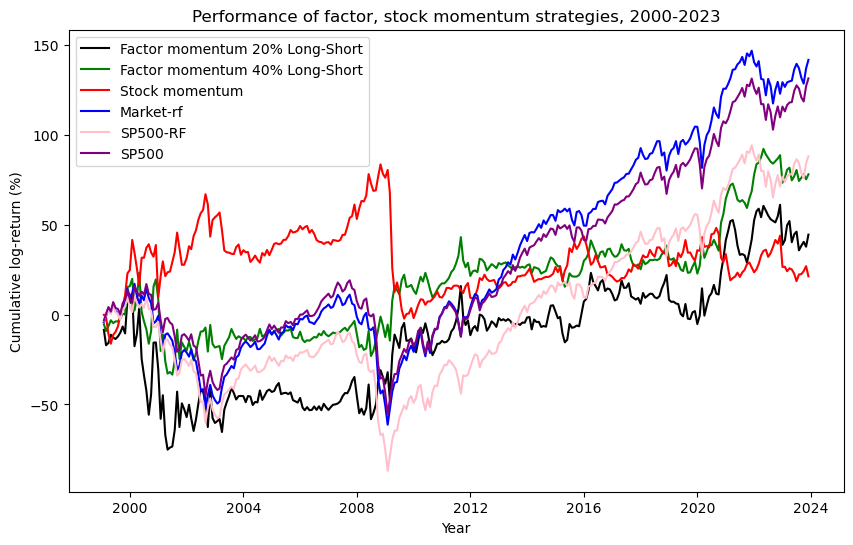

In [158]:
# the data period is from 2000-2023, use the 62 factors data
# the factor momentum is the strategy return we got in Table 1 Panel A, with L=1, H=1
# the stock momentum is the UMD factor in FF5_UMD data
# the market factor is the Mkt-RF in FF5_UMD data
# the risk-free rate is the RF in FF5_UMD data
# the market is the sum of Mkt-RF and RF

figure4_factor_mom = pd.concat([LS1_1_1, LS2_1_1], axis=1)
figure4_factor_mom.columns = ['LS1_1_1', 'LS2_1_1']
figure4_factor_mom.dropna(inplace=True)
figure4_stock_mom = table2_FF5_UMD['UMD'].copy()
figure4_stock_mom.columns = ['UMD']
MKT_RET = table2_FF5_UMD[['Mkt-RF', 'RF']].copy()
MKT_RET = pd.merge(MKT_RET, sp_500, on='date')
MKT_RET = MKT_RET.rename(columns={'sprtrn': 'SP500'})
MKT_RET.columns = ['Mkt-RF', 'RF', 'SP500']
MKT_RET['MKT'] = MKT_RET['RF'] + MKT_RET['Mkt-RF'] 
MKT_RET['SP500-RF'] = MKT_RET['SP500'] - MKT_RET['RF']
MKT_RET.drop(['RF'], axis=1, inplace=True)

PL_cruve = pd.concat([figure4_factor_mom, figure4_stock_mom, MKT_RET], axis=1)
PL_cruve.columns = ['LS1_1_1', 'LS2_1_1', 'UMD','Mkt-RF', 'SP500', 'MKT', 'SP500-RF']
PL_cruve.dropna(inplace=True)

cumulative_log_returns = np.log(PL_cruve+1).cumsum() * 100
plt.figure(figsize=(10, 6))
plt.plot(cumulative_log_returns['LS1_1_1'], color='black', label='Factor momentum 20% Long-Short')
plt.plot(cumulative_log_returns['LS2_1_1'], color='green', label='Factor momentum 40% Long-Short')
plt.plot(cumulative_log_returns['UMD'], color='red', label='Stock momentum')
plt.plot(cumulative_log_returns['Mkt-RF'], color='blue', label='Market-rf')
#plt.plot(cumulative_log_returns['MKT'], color='orange', label='Market')
plt.plot(cumulative_log_returns['SP500-RF'], color='pink', label='SP500-RF')
plt.plot(cumulative_log_returns['SP500'], color='purple', label='SP500')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative log-return (%)")
plt.title("Performance of factor, stock momentum strategies, 2000-2023")
plt.show()

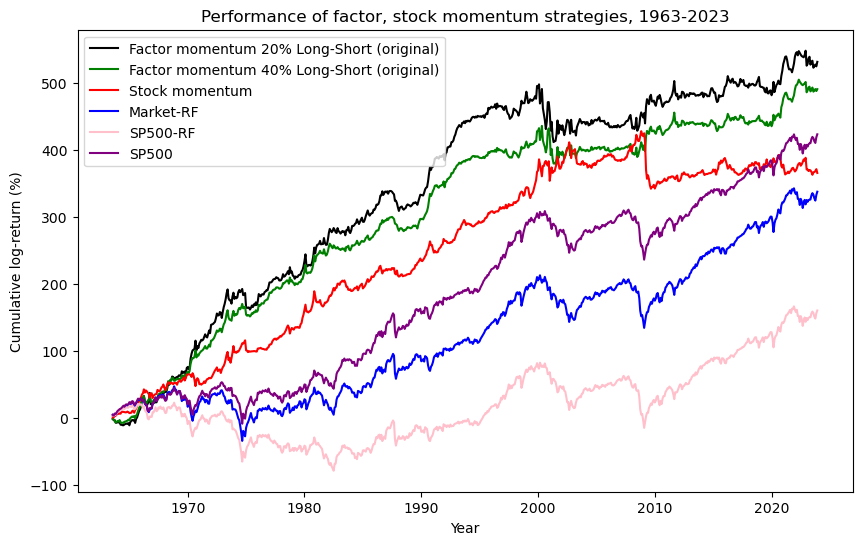

In [149]:
# the data period is from 1963-2023, use the 50 factors data, the original data
# the factor momentum is the strategy return we got in Table 1 Panel A, with L=1, H=1
# the stock momentum is the UMD factor in FF5_UMD data
# the market factor is the Mkt-RF in FF5_UMD data
# the risk-free rate is the RF in FF5_UMD data
# the market is the sum of Mkt-RF and RF

table2_ff5 = pd.read_csv("data/FF5_monthly.csv")
table2_UMD = pd.read_csv("data/FF_Momentum_monthly.csv")
table2_ff5.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
table2_UMD.columns = ['date', 'UMD']
table2_ff5['date'] = pd.to_datetime(table2_ff5['date'], format='%Y%m')
table2_UMD['date'] = pd.to_datetime(table2_UMD['date'], format='%Y%m')
table2_ff5.set_index('date', inplace=True)
table2_UMD.set_index('date', inplace=True)

table_test = pd.merge(table2_ff5, table2_UMD, on='date')
table_test = table_test[['Mkt-RF','SMB','HML','RMW','CMA','RF','UMD']]/ 100

table_test = pd.merge(table_test, sp_500, on='date')
table_test['SP500'] = table_test['sprtrn']

# the original data from 1963 to 2023
figure4_factor_test = pd.concat([LS1_1_1_original,LS2_1_1_original], axis=1)
figure4_stock_test = table_test[['UMD','Mkt-RF', 'RF', 'SP500']].copy()
figure4_stock_test.columns = ['UMD', 'Mkt-RF', 'RF', 'SP500']
figure4_stock_test['MKT'] = figure4_stock_test['RF'] + figure4_stock_test['Mkt-RF']
figure4_stock_test['SP500-RF'] = figure4_stock_test['SP500'] - figure4_stock_test['RF']
figure4_stock_test.drop(['RF'], axis=1, inplace=True)
PL_cruve_test = pd.concat([figure4_factor_test,figure4_stock_test], axis=1)
PL_cruve_test.columns = ['LS1_1_1_original', 'LS2_1_1_original', 'UMD', 'Mkt-RF', 'SP500','MKT','SP500-RF']
PL_cruve_test.dropna(inplace=True)
cumulative_log_returns = np.log(PL_cruve_test+1).cumsum() * 100
plt.figure(figsize=(10, 6))
plt.plot(cumulative_log_returns['LS1_1_1_original'], color='black', label='Factor momentum 20% Long-Short (original)')
plt.plot(cumulative_log_returns['LS2_1_1_original'], color='green', label='Factor momentum 40% Long-Short (original)')
plt.plot(cumulative_log_returns['UMD'], color='red', label='Stock momentum')
plt.plot(cumulative_log_returns['Mkt-RF'], color='blue', label='Market-RF')
#plt.plot(cumulative_log_returns['MKT'], color='orange', label='Market')
plt.plot(cumulative_log_returns['SP500-RF'], color='pink', label='SP500-RF')
plt.plot(cumulative_log_returns['SP500'], color='purple', label='SP500')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative log-return (%)")
plt.title("Performance of factor, stock momentum strategies, 1963-2023")
plt.show()